In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import keras_tuner
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras import layers

In [2]:
# Loading already optimez dataset from Advanced data analytics course
df = pd.read_csv('cars_optimized.csv')
df.drop("Unnamed: 0", axis=1, inplace=True)

In [3]:
df.head()

,Prod. year,Leather interior,Mileage,Cylinders,Wheel,price_levy_combined,Airbags_bins,Engine volume int,Turbo,Coupe,...,Manufacturer_BMW,Manufacturer_CHEVROLET,Manufacturer_FORD,Manufacturer_HONDA,Manufacturer_HYUNDAI,Manufacturer_MERCEDES-BENZ,Manufacturer_NISSAN,Manufacturer_TOYOTA,Manufacturer_VOLKSWAGEN,Manufacturer_infrequent_sklearn
0,2010,0,186005,6.0,0,14727,2,3.5,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2011,1,192000,6.0,0,17639,2,3.0,0.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2006,1,200000,4.0,1,8467,1,1.3,0.0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2011,0,168966,4.0,0,4469,0,2.5,0.0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2014,0,91901,4.0,0,12172,1,1.3,0.0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# everything else except target variable
X = df.drop("price_levy_combined", axis=1)
# only target variable
y = df["price_levy_combined"]

# Split to 70% for training data and 30% for validation and testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
# Split the rest 30% for 15% validation and 15% training
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [5]:
def build_model(hp):
    # iniatlize sequential test neural network
    model = keras.Sequential()

    # first layer, batch normalization + input shape, same as in typical neural network
    #model.add(layers.BatchNormalization(input_shape=(len(X.columns),)),)
    model.add(
        layers.Dense(input_shape=(len(X.columns),),
            # Tune number of units separately.
            units=hp.Int(f"imput", min_value=16, max_value=128, step=4),
            activation=hp.Choice("activation", ["relu"]),
        )
    )
    # add the first actual layer including the regularizer
    model.add(
        layers.Dense(
            # Tune number of units separately.
            units=hp.Int(f"units_0", min_value=8, max_value=86, step=4),
            activation=hp.Choice("activation", ["relu"]),
            kernel_regularizer=keras.regularizers.l1(l1=0.1)
        )
    )
        
    # automate a dropout layer
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.1))

    # try additional layers, 1 or 2 extra layers
    for i in range(hp.Int("num_layers", 1, 2)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i + 1}", min_value=4, max_value=86, step=4),
                activation=hp.Choice("activation", ["relu"]),
            )
        )

    # output layer, only one node since this is regression
    model.add(layers.Dense(1))

    # automate learning rate tests
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    # compile the test neural network
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse"
    )

    return model


# build the model + use RandomSearch to actually search the best options for our neural network
build_model(keras_tuner.HyperParameters())

# use val_loss as the objective, because regression tasks do not have accuracy
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=5,
    executions_per_trial=3,
    overwrite=True,
    directory="optimizations",
    project_name="regression1test",
)

# start searching
#tuner.search(X_train, y_train, epochs=400, validation_data=(X_val, y_val))

c:\Users\ksobolev\Documents\github\school\Advanced-data-analytics\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
#tuner.results_summary()

In [7]:
#models = tuner.get_best_models(num_models=2)
#best_model = models[0]
#best_model.summary()

In [8]:
model = keras.Sequential(
    [
        layers.Dense(100, activation="relu", input_shape=(len(X.columns),)),
        layers.Dense(84, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.1)),
        layers.Dense(56, activation="relu"),
        layers.Dense(84, activation="relu"),
        layers.Dense(1)
    ]
)

# optimal learning rate from keras tuner
optimal_lr = 0.005275753769624545

# select the optimizer and loss function
# you can try rmsprop also as optimizer, or stochastic gradient descent
model.compile(optimizer=keras.optimizers.Adam(), loss='mse')
# print out the summary of your model
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 100)            │         3,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 84)             │         8,484 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 56)             │         4,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 84)             │         4,788 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,817 (85.22 KB)

 Trainable params: 21,817 (85.22 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.fit(x=X_train, y=y_train, epochs=1200, validation_data=(X_val, y_val))

Epoch 1/800
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 297505472.0000 - val_loss: 166167792.0000
Epoch 2/800
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 172393824.0000 - val_loss: 174423168.0000
Epoch 3/800
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 169829264.0000 - val_loss: 177338544.0000
Epoch 4/800
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 168513264.0000 - val_loss: 166510016.0000
Epoch 5/800
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 165385216.0000 - val_loss: 168850992.0000
Epoch 6/800
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 160215728.0000 - val_loss: 201024144.0000
Epoch 7/800
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 168862304.0000 - val_loss: 166725328.0000
Epoch 8/800
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 166715904.0000 - val_loss: 163888720.0000
Epoch 9/800
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 170315296.0000 - val_loss: 173265504.0000
Epoch 10/800
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - l

<h2>Metrics</h2>

In [10]:
%matplotlib inline

<Axes: >

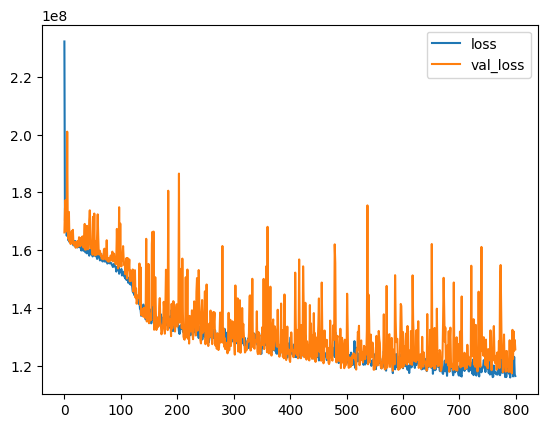

In [11]:
# try to look if the model is actually training 
# => the error is going downwards
# if using validation data, you get two lines
# in this case, see if the lines follow a similar trend 
# (they don't always overlap with complex data, the trend is more important)
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

# other notes:
# if your validation loss is fluctuating a lot, the test data set
# might not be a good sample / representation of the whole dataset
# try to get more data or try shuffling the dataset for a better sample
# if your validation loss FLUCTUATES EXTREMELY: remember to create 
# the neural network again completely (Sequential etc.), otherwise you might fit your 
# model to your previous model version weights

# we'll also study later methods on how to select the best epoch from 
# the training history

# a common reason why a numeric neural network for regression might overfit
# is that you might have too many variables but too little data

In [12]:
# compare test error values to training error values
# the model is often good when these error values are similar
# even if you training metrics above didn't overlap
# you might still get very close values in evaluation => more important

# compare the final model loss/evaluation values
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
131966152.0

Train data evaluation:
119858528.0


In [13]:
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step


,Test True Y,Model Predictions
0,8000,8653.468750
1,19230,17714.753906
2,3500,6405.967773
3,5500,20137.332031
4,16405,22828.632812
...,...,...
2079,26809,22679.691406
2080,11504,22667.521484
2081,21482,20639.523438
2082,5645,13148.200195


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

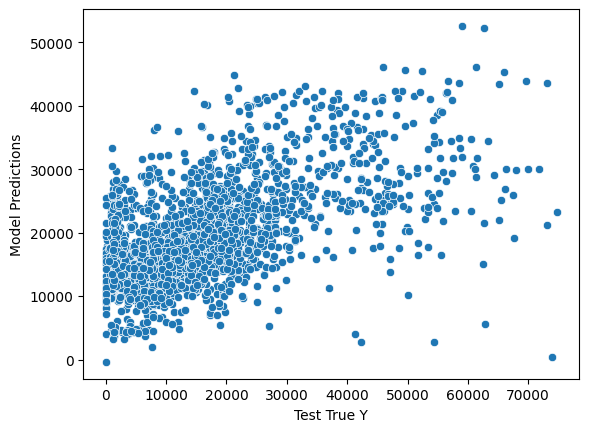

In [14]:
# these values follow a linear line = good predictions
# we basically compare the predicted values 
# to true test values and see the differences
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

In [15]:
# MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
8421.54 $

MSE
131966017.63 $^2

RMSE:
11487.65 $

R-squared:
0.31

Explained variance score:
0.33


C:\Users\ksobolev\AppData\Local\Temp\ipykernel_15968\130455776.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


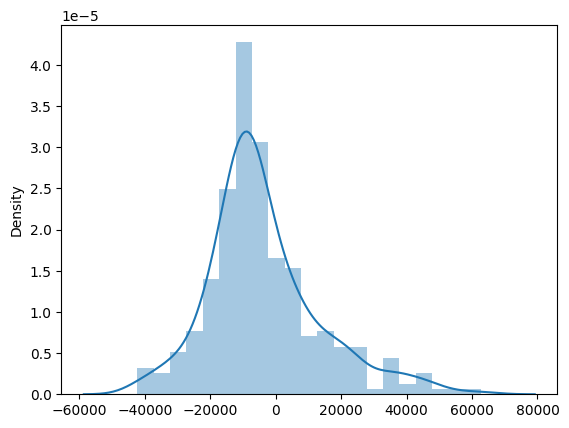

In [16]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()